In [1]:
!pip install --quiet langchain langchain_community chromadb langchain_openai langgraph youtube-transcript-api pytube yt_dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.1/485.1 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.0 MB/s eta 0:

In [23]:
import os
import datetime
import bs4
import uuid
from google.colab import userdata
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate, PromptTemplate
from langchain.load import loads, dumps
from operator import itemgetter
from typing import Literal, Optional, Tuple
from pydantic import BaseModel, Field
from langchain.utils.math import cosine_similarity
from langchain_community.document_loaders import YoutubeLoader
from yt_dlp import YoutubeDL
from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore

os.environ['LANGSMITH_API_KEY'] = userdata.get('LANG_TOKEN')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['OPENAI_API_KEY'] = userdata.get('OAI_TOKEN')

In [3]:
loader = WebBaseLoader('https://en.wikipedia.org/wiki/Belgium')

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=texts, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

In [ ]:
def format_docs(docs):
  return '\n\n'.join(doc.page_content for doc in docs)

chain = (
    {'context': retriever | format_docs, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("What is Belgium most famous for?")

# Multi-Query

In [ ]:
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_template = ChatPromptTemplate.from_template(template)

gen_queries = (
    prompt_template
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split('\n'))
)

def get_unique_docs(docs):
  dump_docs = [dumps(doc) for sublist in docs for doc in sublist]
  unique_docs = list(set(dump_docs))
  return [loads(doc) for doc in unique_docs]

unique_docs = get_unique_docs(docs)

retrieval_chain = (
    gen_queries
    | retriever.map()
    | get_unique_docs
)

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {'context': retrieval_chain, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("What is Belgium most famous for?")

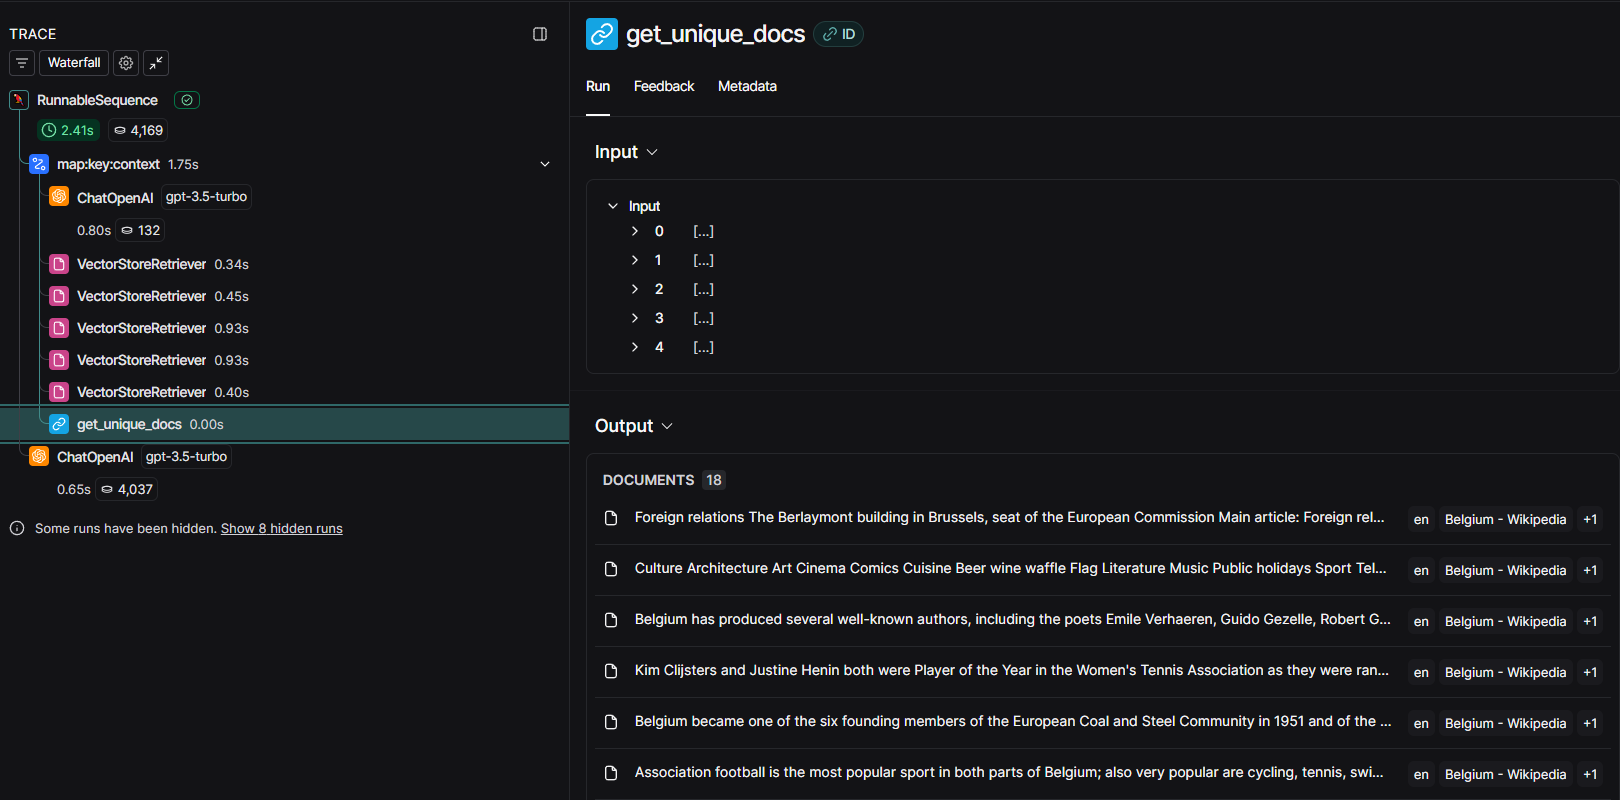

# RRF

In [ ]:
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_template = ChatPromptTemplate.from_template(template)

gen_queries = (
    prompt_template
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split('\n'))
)

def reciprocal_rank_fusion(results: list[list], k=60):
  fused_scores = {}

  for docs in results:
    for rank, doc in enumerate(docs):
      doc_str = dumps(doc)
      if doc_str not in fused_scores:
        fused_scores[doc_str] = 0
      previous_score = fused_scores[doc_str]
      fused_scores[doc_str] += 1 / (rank + k)

  reranked_results = [
      (loads(doc), score)
      for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
  ]

  return reranked_results

retrieve_chain = (
    gen_queries
    | retriever.map()
    | reciprocal_rank_fusion
)

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {'context': retrieve_chain, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("Who governs Belgium?")

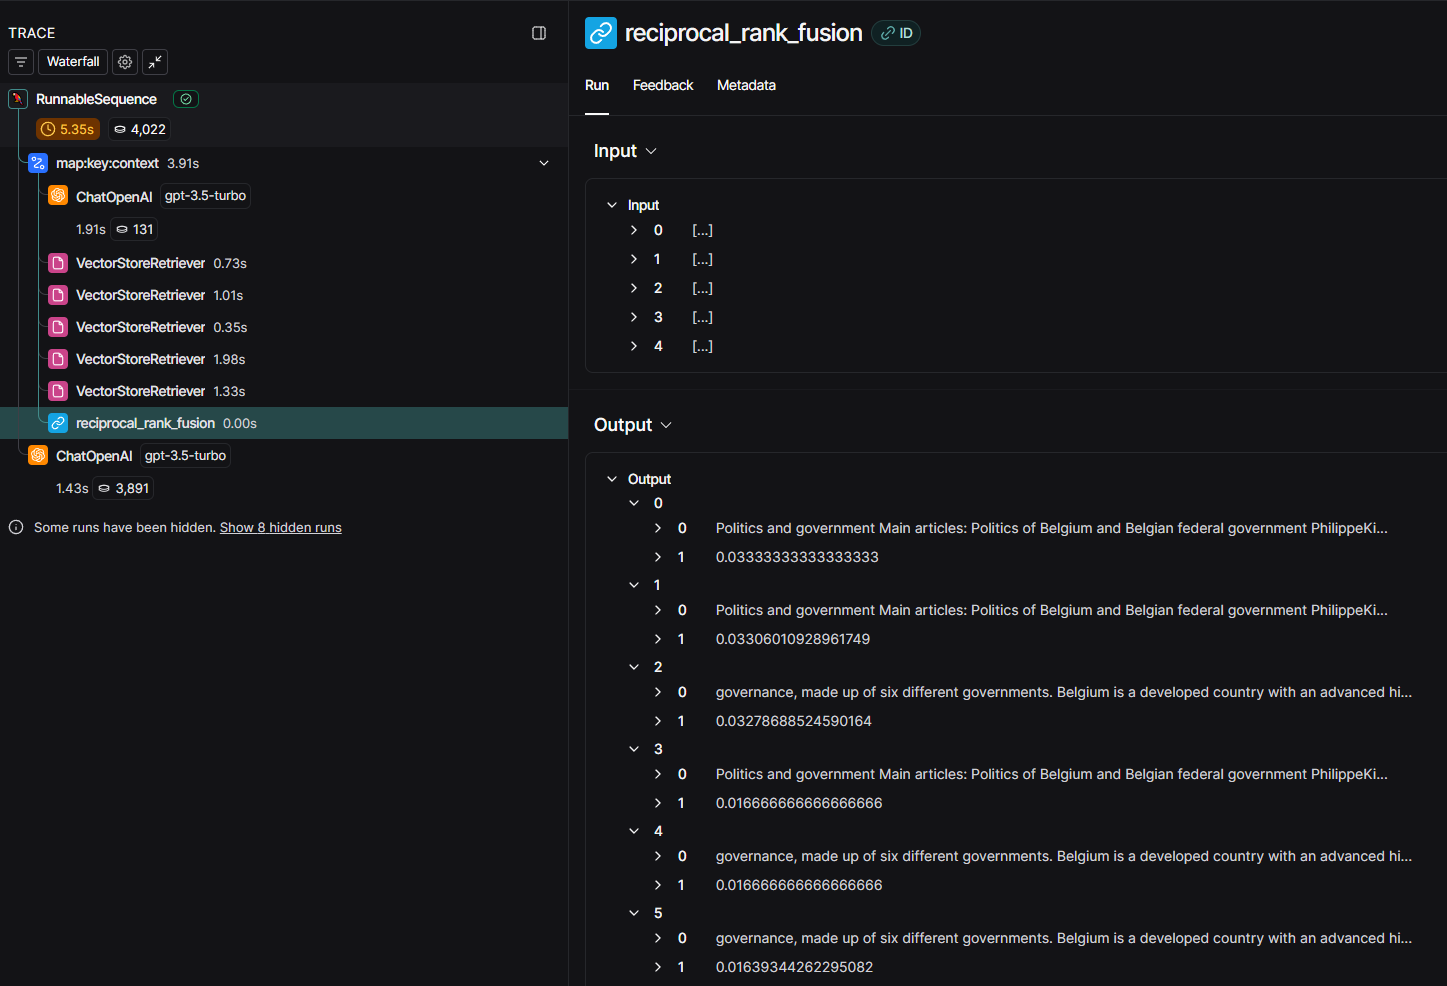

# Decomposition

In [ ]:
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""

prompt_decomp = ChatPromptTemplate.from_template(template)

gen_queries_decomp = (
    prompt_decomp
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)
question = "Is Belgium important?"
questions = gen_queries_decomp.invoke({"question": question})
questions

template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {qa_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

prompt = ChatPromptTemplate.from_template(template)

def format_qa_pair(question, answer):
  formatted_str = ""
  formatted_str += f'Question: {question}\nAnswer: {answer}\n\n'
  return formatted_str.strip()

qa_pairs = ""
for q in questions:
  chain = (
      {'context': itemgetter('question') | retriever,
       'question': itemgetter('question'),
       'qa_pairs': itemgetter('qa_pairs')}
      | prompt
      | llm
      | StrOutputParser()
  )

  answer = chain.invoke({'question': q, 'qa_pairs': qa_pairs})
  qa_pair = format_qa_pair(q, answer)
  qa_pairs = qa_pairs + '\n --- \n' + qa_pair

answer

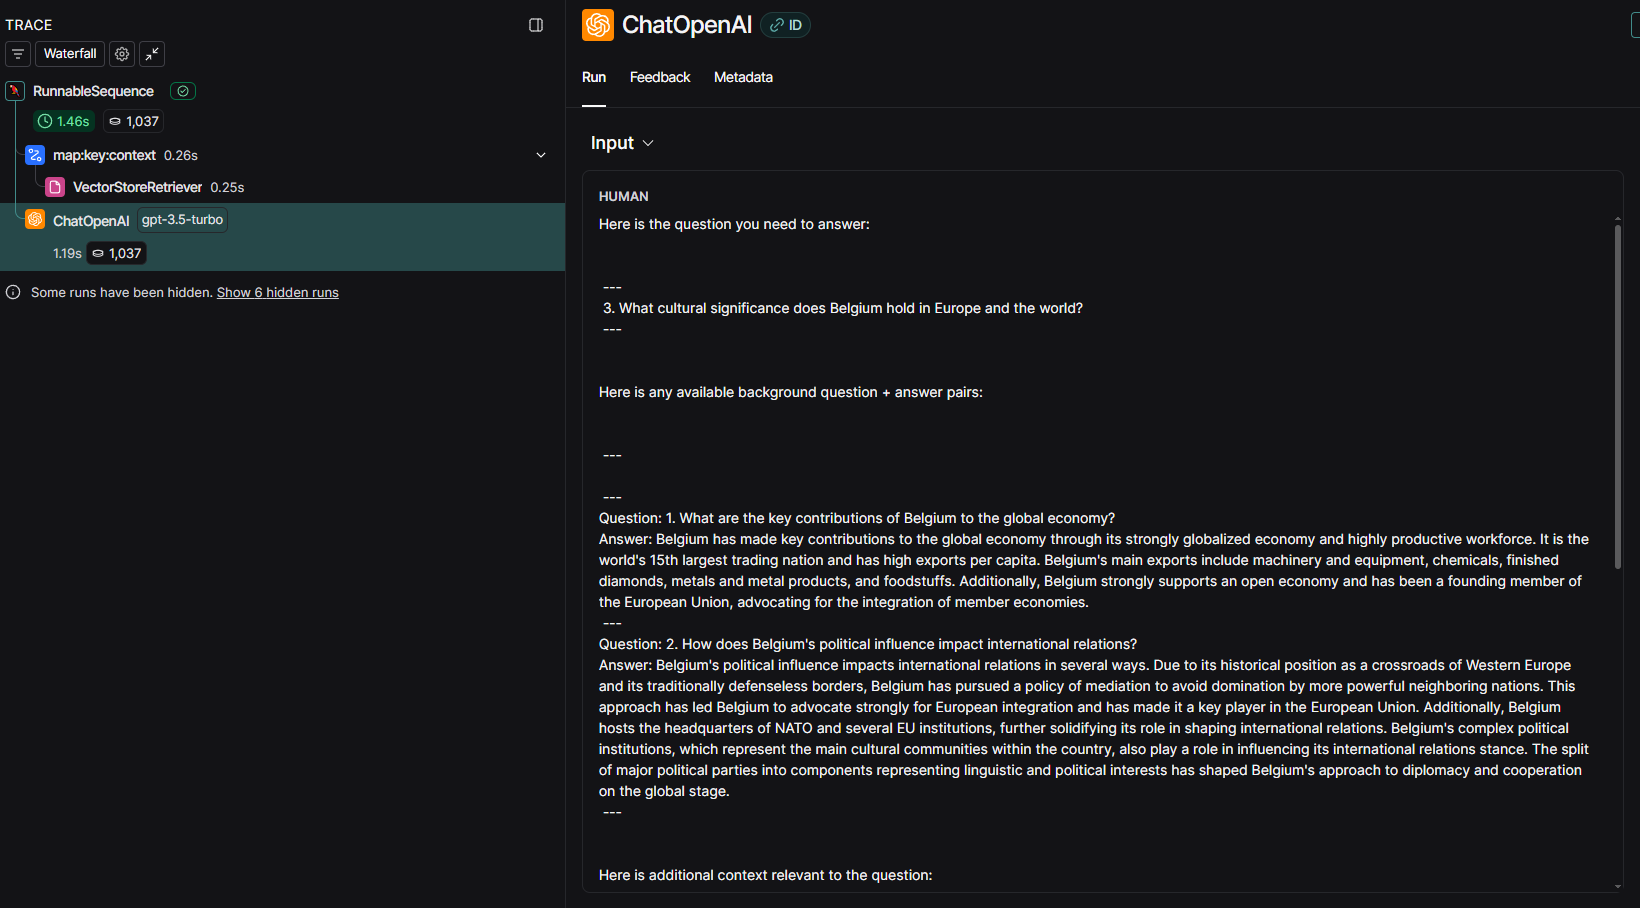

In [ ]:
prompt = hub.pull('rlm/rag-prompt')

def retrieve_and_rag(q, prompt_rag, sub_q_chain):
  sub_questions = sub_q_chain.invoke({'question': q})

  rag_results = []

  for sub_q in sub_questions:
    relevant_docs = retriever.invoke(sub_q)
    chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    answer = chain.invoke({'context': relevant_docs, 'question': sub_q})
    rag_results.append(answer)

  return rag_results, sub_questions

question = "Is Belgium important?"
answers, questions = retrieve_and_rag(question, prompt, gen_queries_decomp)

def format_qa_pairs(questions, answers):
  formatted_str = ""
  for i, (q, a) in enumerate(zip(questions, answers), start=1):
    formatted_str += f'QA pair {i}: Question: {q}, Answer: {a}\n\n'
  return formatted_str

context = format_qa_pairs(questions, answers)

template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    prompt
    | llm
    | StrOutputParser()
)

chain.invoke({'context': context, 'question': question})

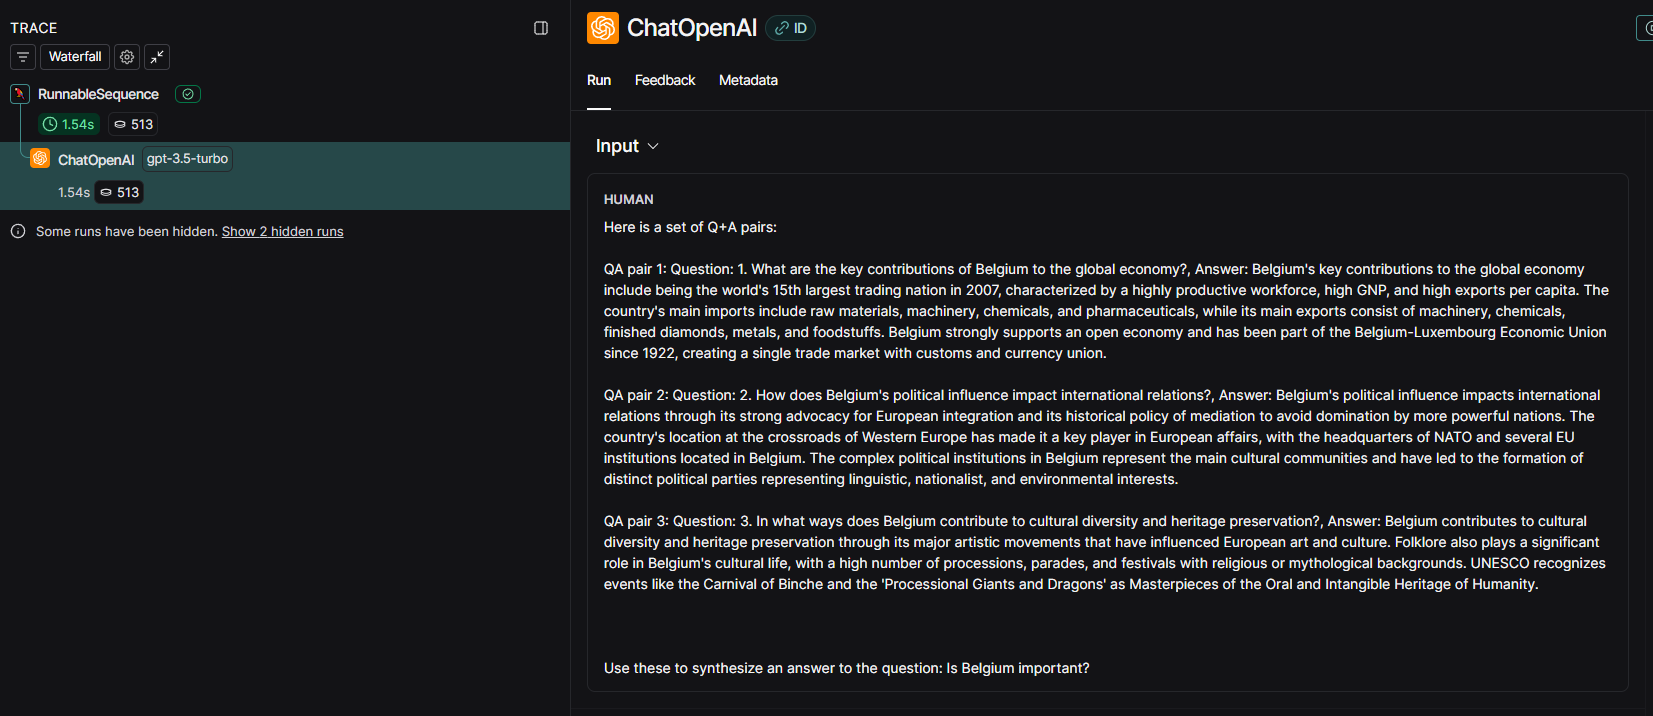

# Step back


In [ ]:
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jeff Bezos’s was born in what country?",
        "output": "what is Jeff Bezos’s personal history?",
    },
]

example_prompt = ChatPromptTemplate.from_messages(
    [
        ('human', '{input}'),
        ('ai', '{output}')
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step back question, which is easier to answer. Here are a few examples:""",
        ),
        few_shot_prompt,
        ('user', '{question}'),
    ]
)

gen_queries_step_back = (
    prompt
    | llm
    | StrOutputParser()
)

question = 'Did fries originate in Belgium?'
gen_queries_step_back.invoke({'question': question})

response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""

response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        'normal_context': RunnableLambda(lambda x: x['question']) | retriever,
        'step_back_context': gen_queries_step_back | retriever,
        'question': lambda x: x['question'],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({'question': question})

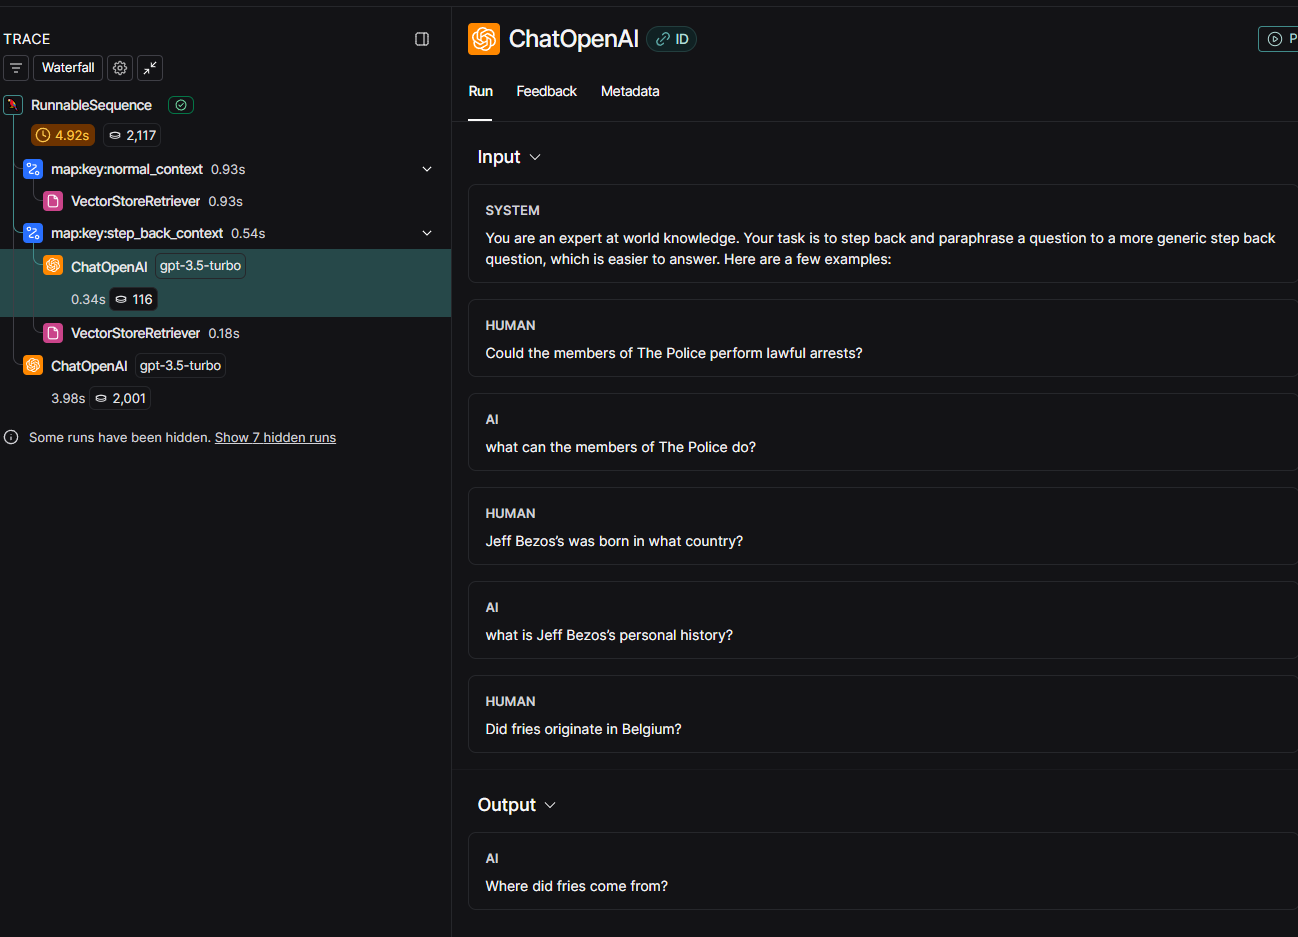

In [ ]:
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""

prompt_hyde = ChatPromptTemplate.from_template(template)

gen_docs_for_retrieval = (
    prompt_hyde
    | llm
    | StrOutputParser()
)

question = 'Who are the most influencial Belgians?'
gen_docs_for_retrieval.invoke({'question': question})

retrieve_chain = (
    gen_docs_for_retrieval
    | retriever
)

retrieved_docs = retrieve_chain.invoke({'question': question})

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    prompt
    | llm
    | StrOutputParser()
)

chain.invoke({'context': retrieved_docs, 'question': question})

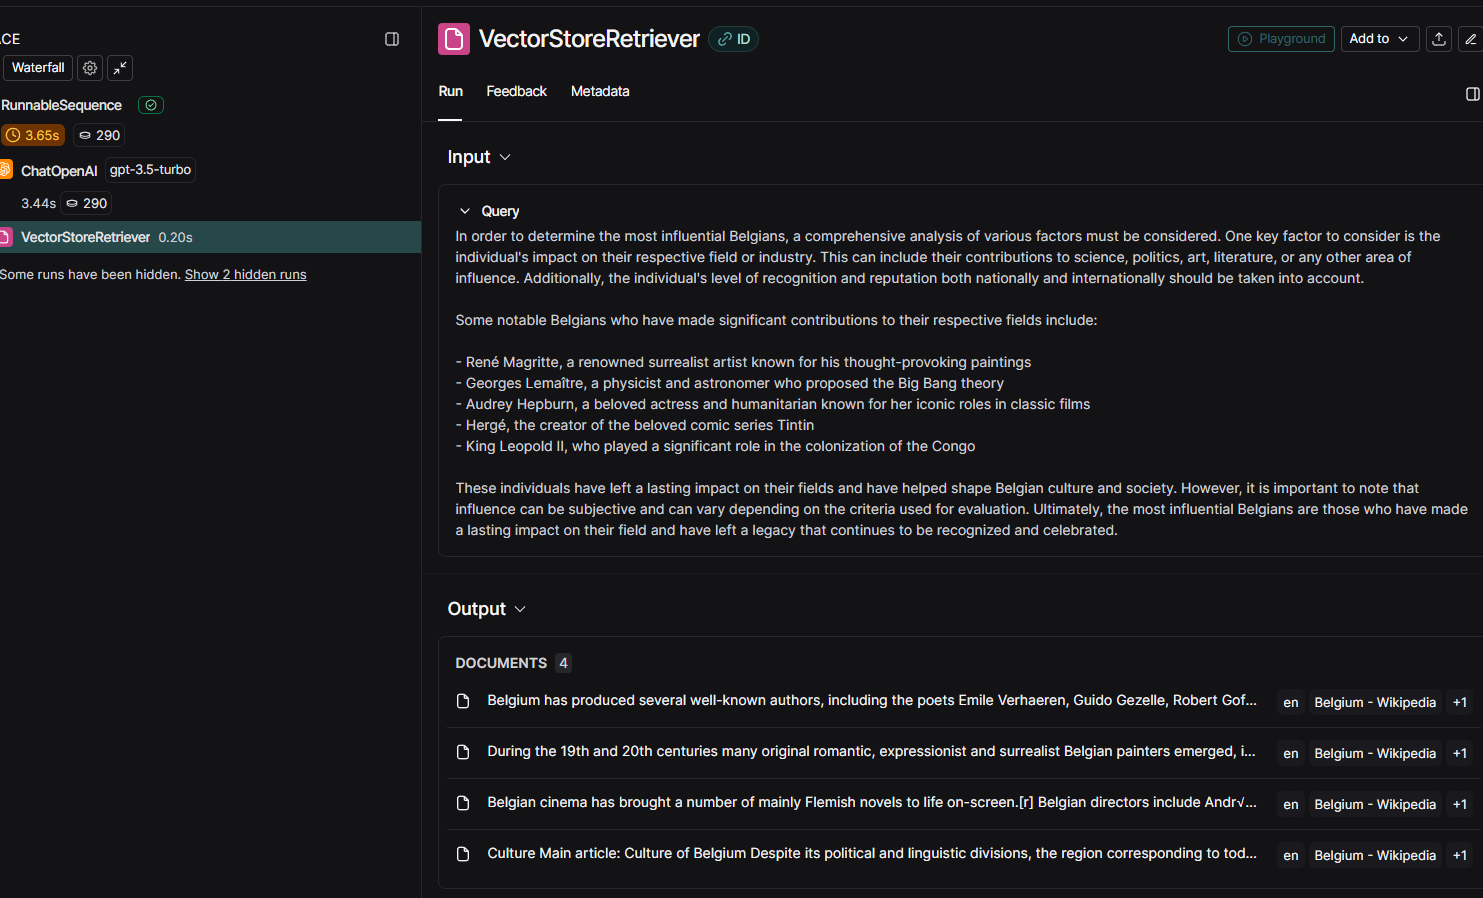

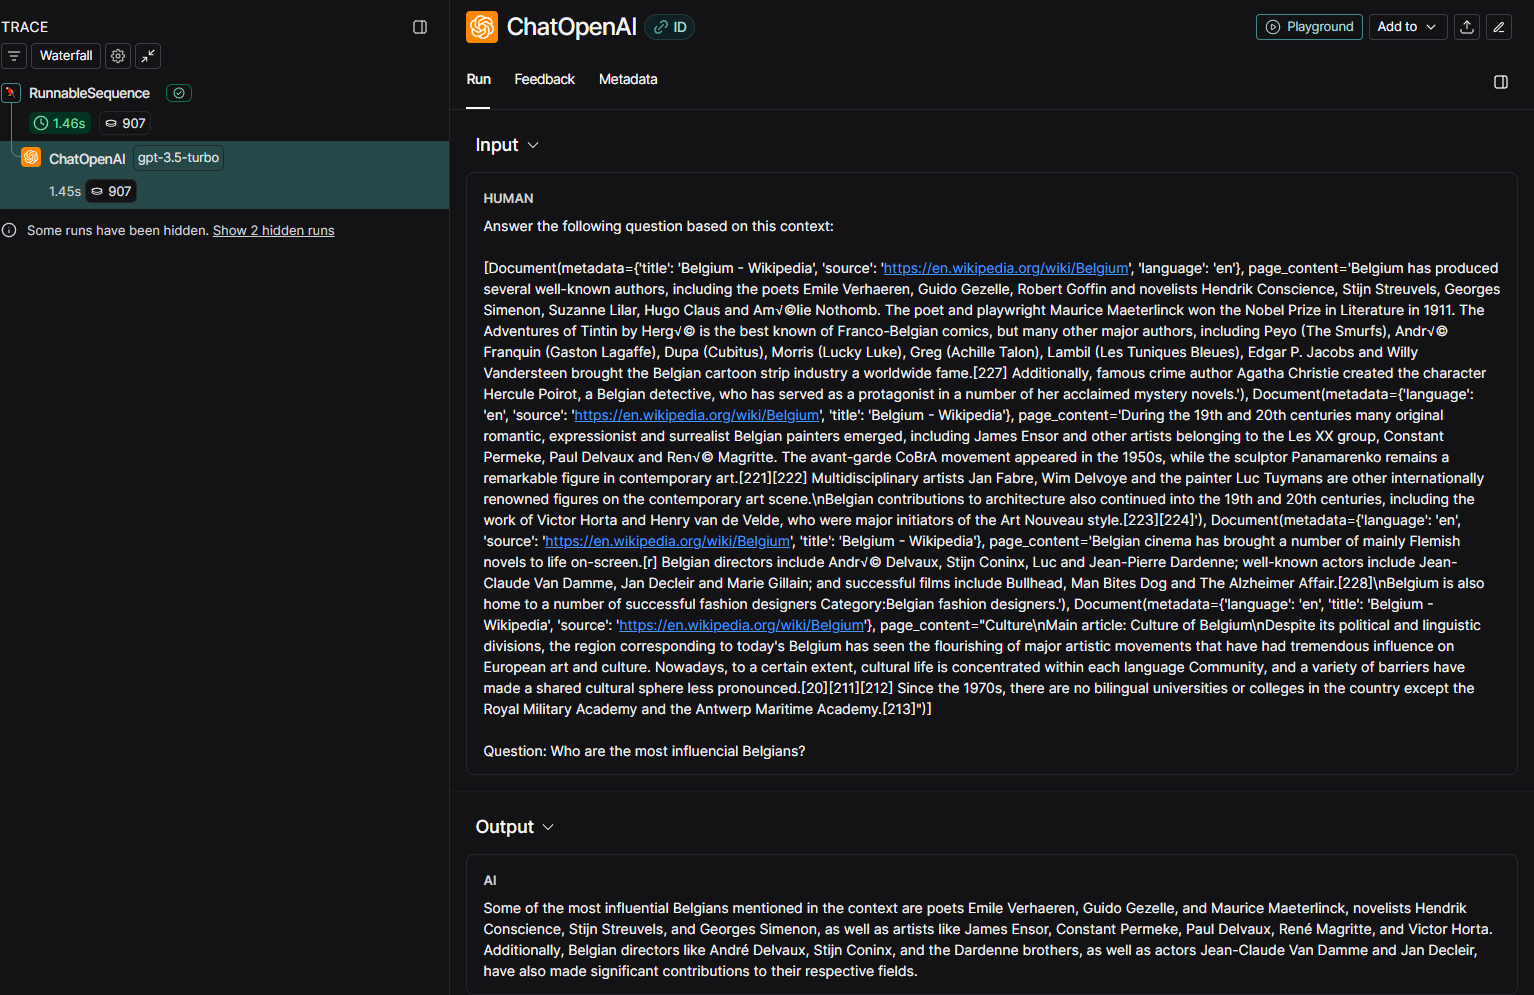

# Routing to different retrievers

In [ ]:
class RouteQuery(BaseModel):
  datasource: Literal['france_wiki', 'belgium_wiki', 'switzerland_wiki'] = Field(
      ...,
      decription='The relevant datasource to use for the query'
  )

structured_llm = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to the appropriate data source.

Based on the country the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human', '{question}'),
    ]
)

router = (
    prompt
    | structured_llm
)

question = 'Who was Napoleon?'

def pick_route(result):
  if 'france_wiki' in result.datasource.lower():
    return 'route for france wiki'
  elif 'belgium_wiki' in result.datasource.lower():
    return 'route for belgium wiki'
  elif 'switzerland_wiki' in result.datasource.lower():
    return 'route for switzerland wiki'
  else:
    return 'route for none of the listed data sources'

chain = (
    router
    | RunnableLambda(pick_route)
)

chain.invoke({'question': question})

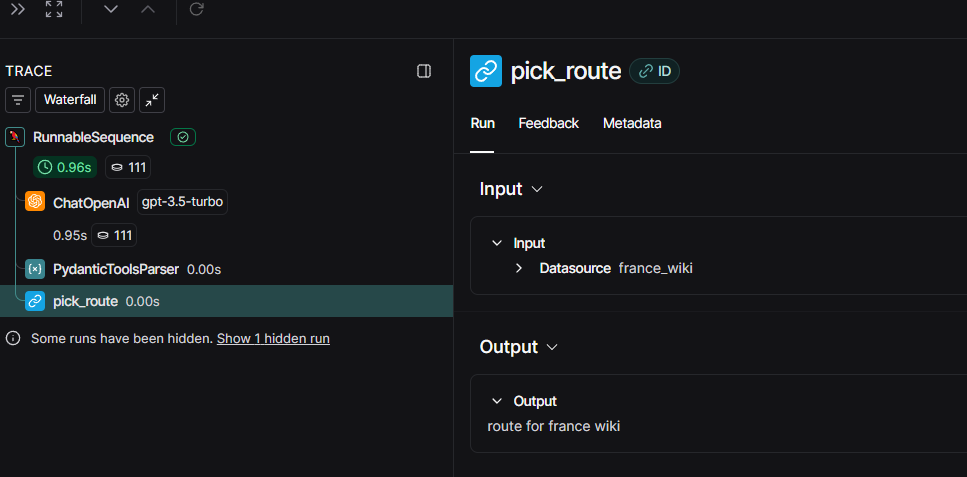

In [ ]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{question}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{question}"""

embeddings = OpenAIEmbeddings()
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

def prompt_router(input):
  question_embedding = embeddings.embed_query(input['question'])
  similarity = cosine_similarity([question_embedding], prompt_embeddings)[0]
  most_similar = prompt_templates[similarity.argmax()]
  print('Using MATH' if most_similar == math_template else 'Using PHYSICS')
  return PromptTemplate.from_template(most_similar)

chain = (
    RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

chain.invoke({'question': 'Whats the Pythagorean theorem?'})

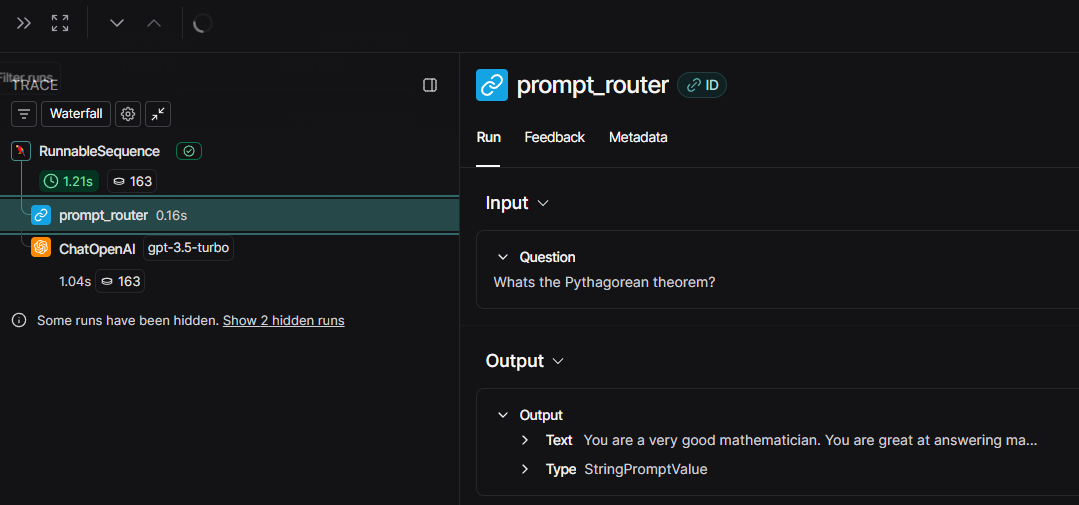

# Query construction

In [7]:
url = 'https://www.youtube.com/watch?v=n2Tru4Qa3pc'

loader = YoutubeLoader.from_youtube_url(url)
docs = loader.load()

with YoutubeDL({"quiet": True, "extract_flat": True, "skip_download": True}) as ydl:
    info = ydl.extract_info(url, download=False)

meta = {
    "title": info.get("title"),
    "channel": info.get("uploader"),
    "channel_id": info.get("channel_id"),
    "upload_date": info.get("upload_date"),
    "duration": info.get("duration"),
    "view_count": info.get("view_count"),
    "like_count": info.get("like_count"),
    "categories": info.get("categories"),
    "url": url,
}

for doc in docs:
  doc.metadata.update({k: v for k, v in meta.items() if v is not None})

print(docs[0].metadata)

{'source': 'n2Tru4Qa3pc', 'title': 'YUNDI plays Mozart: Piano Sonata No. 11 in A Major, K. 331 "Alla Turca": III. Rondo alla Turca', 'channel': 'Warner Classics', 'channel_id': 'UC1pfwysp1EC5P4qE-Eo97HA', 'upload_date': '20240209', 'duration': 203, 'view_count': 1429422, 'like_count': 18598, 'categories': ['Music'], 'url': 'https://www.youtube.com/watch?v=n2Tru4Qa3pc'}


In [14]:
class VideoSearch(BaseModel):
  content_search: str = Field(
      ...,
      description='Similarity search query applied to video transcripts.'
  )
  title_search: str = Field(
      ...,
      description='Similarity search query applied to video titles.'
  )
  min_view_count: Optional[int] = Field(
      None,
      description="Minimum view count filter.",
  )
  max_view_count: Optional[int] = Field(
      None,
      description="Maximum view count filter.",
  )
  earliest_upload_date: Optional[datetime.date] = Field(
      None,
      description="Earliest upload date filter.",
  )
  latest_upload_date: Optional[datetime.date] = Field(
      None,
      description="Latest upload date filter.",
  )
  min_length_sec: Optional[int] = Field(
      None,
      description="Minimum video length in seconds.",
  )
  max_length_sec: Optional[int] = Field(
      None,
      description="Maximum video length in seconds.",
  )

  def pretty_print(self) -> None:
    for field in self.__fields__:
      if getattr(self, field) is not None:
          print(f'{field}: {getattr(self, field)}')


system = """You are an expert at converting user questions into database queries. \
You have access to a database of music videos about classical piano music. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human', '{question}')
    ]
)
structured_llm = llm.with_structured_output(VideoSearch)
chain = prompt | structured_llm

chain.invoke({'question': 'beethovens most famous pieces'}).pretty_print()

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1949: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


content_search: Beethoven
title_search: famous pieces
min_view_count: 1000000


/tmp/ipython-input-2657661969.py:36: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  for field in self.__fields__:


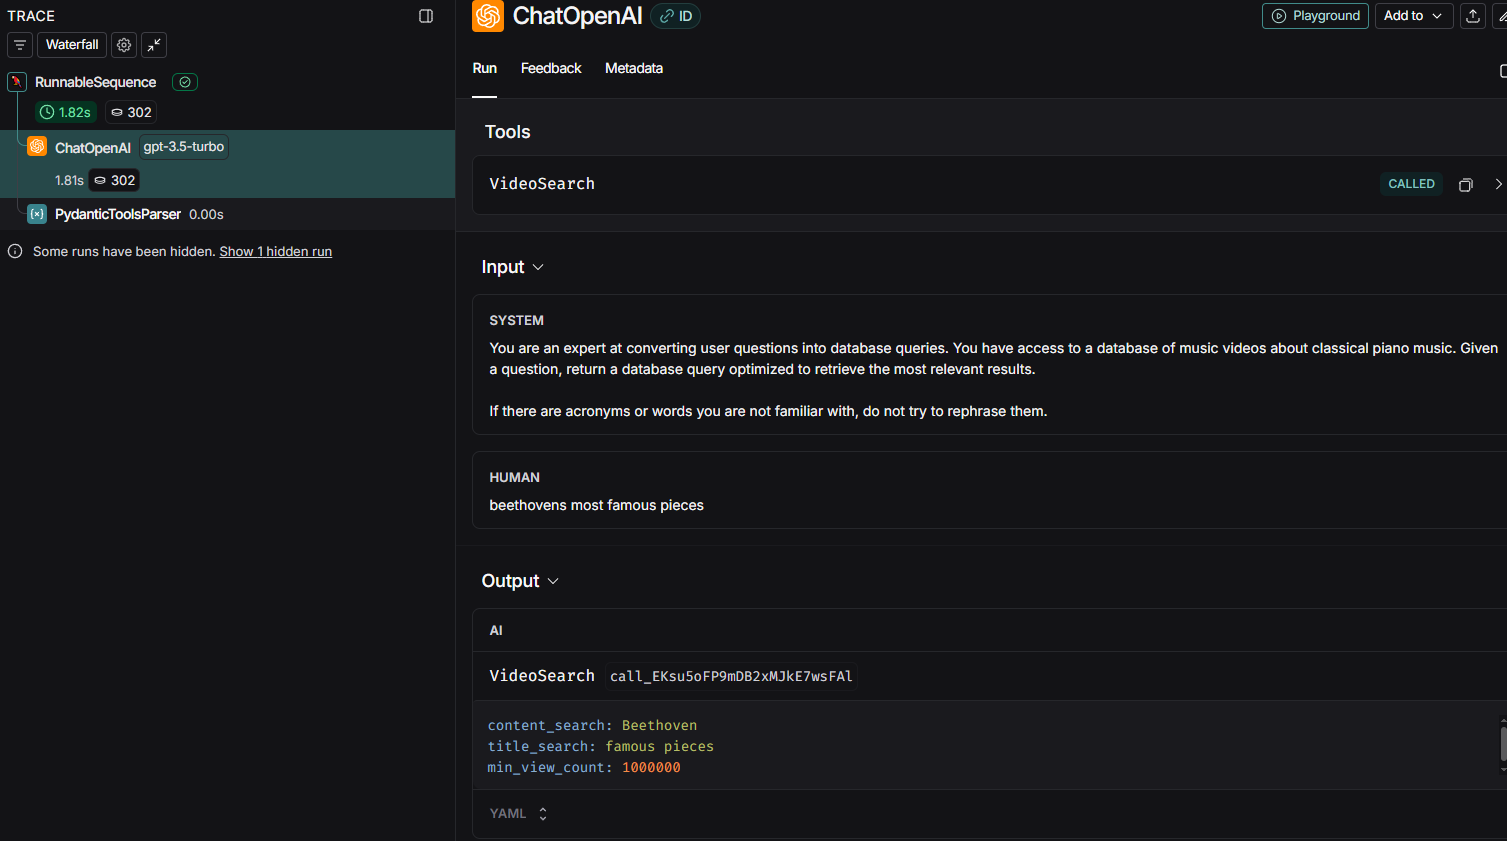

# Multi-representation indexing

In [41]:
loader = WebBaseLoader('https://www.britannica.com/technology/artificial-intelligence')
docs = loader.load()

template = 'Summarize the following document:\n\n{doc}'
prompt = ChatPromptTemplate.from_template(template)
chain = (
    {'doc': lambda x: x.page_content}
    | prompt
    | llm
    | StrOutputParser()
)

summaries = chain.batch(docs)
print(summaries)

vectorstore = Chroma(collection_name='summaries',
                     embedding_function=OpenAIEmbeddings())

store = InMemoryByteStore()
id_key = 'doc_id'

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in docs]

summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

['The document provides an overview of artificial intelligence (AI), including its definition, examples, types, applications, companies involved, and facts. It discusses the ability of digital computers or computer-controlled robots to perform tasks associated with intelligent beings, such as reasoning, discovering meaning, generalizing, and learning from past experiences. The document also explores the history of AI, machine learning, large language models, natural language processing, autonomous vehicles, virtual assistants, and the risks associated with AI.']


In [44]:
query = 'Neural networks in Artificial Intelligence'
sub_docs = vectorstore.similarity_search(query)
sub_docs[0]

retrieved_docs = retriever.get_relevant_documents(query)
retrieved_docs[0].page_content[0:600]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\nArtificial intelligence (AI) | Definition, Examples, Types, Applications, Companies, & Facts | Britannica\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch Britannica\n\n\n\n\n\nClick here to search\n\n\n\n\n\n\n\n\n\n\n\nSearch Britannica\n\n\n\n\n\nClick here to search\n\n\n\n\n\n\n\n   SUBSCRIBE\n\n\n\n   SUBSCRIBE\n\n\nLogin\n\nhttps://premium.britannica.com/premium-membership/?utm_source=premium&utm_medium=nav-login-box&utm_campaign=evergreen\n\n\n\n\n\n\n\n  SUBSCRIBE\n\n\n\n\nHome\nHistory & Society\nScience & Tech\nBiographies\nAnimals & Nature\nGeography & Travel\nArts & Culture\nProCon\nMoney\n\n\nGames & Quizzes\nVideos'